# Align two MERFISH brain sections using original LDDMM with automated landmarks.
#### Version: Using automated landmark points. 

Data source: Vizgen Data Release V1.0. May 2021 (https://info.vizgen.com/mouse-brain-map?submissionGuid=955163f1-3119-42d9-bcbf-e0255e6e7d17) 

Dataset used: Slice 2 Replicate 2, Slice 2 Replicate 3 

Code: Iris Kwon (skwon38@jh.edu)

In [65]:
import os
import matplotlib.pyplot as plt
##### %%time
import torch
import copy
from torch.nn.functional import grid_sample
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad 
import landmark as lm 
import STalign
# from STalign import STalign
dir(STalign)

['LDDMM',
 'LDDMM_3D_to_slice',
 'L_T_from_points',
 'Line2D',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'analyze3Dalign',
 'build_transform',
 'build_transform3D',
 'calculate_tre',
 'clip',
 'cm',
 'copy',
 'defaultdict',
 'download_aba_image_labels',
 'download_aba_ontology',
 'exists',
 'extent_from_x',
 'glob',
 'go',
 'grid_sample',
 'interp',
 'interp3D',
 'join',
 'make_scree',
 'makedirs',
 'normalize',
 'np',
 'nrrd',
 'os',
 'pd',
 'plot_brain_regions',
 'plot_subset_brain_regions',
 'plt',
 'px',
 'rasterize',
 'rasterizePCA',
 'rasterize_with_signal',
 'requests',
 'saveRasters',
 'split',
 'splitext',
 'sys',
 'to_A',
 'to_A_3D',
 'torch',
 'tornado',
 'transform_image_source_to_target',
 'transform_image_source_with_A',
 'transform_image_target_to_source',
 'transform_points_source_to_target',
 'transform_points_target_to_source',
 'v_to_phii',
 'v_to_phii_3D']

In [66]:
os.chdir('/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/stalign_gene_expression/')

# Load target data (S2R3)
source_metadata = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv', index_col=0)
source_gexp = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_by_gene_S2R3.csv', index_col=0)

# Load source data (S2R2) 
target_metadata = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv', index_col=0)
target_gexp = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_by_gene_S2R2.csv',index_col=0)

Text(0.5, 1.0, 'Overlay of Source and Target MERFISH ST Data')

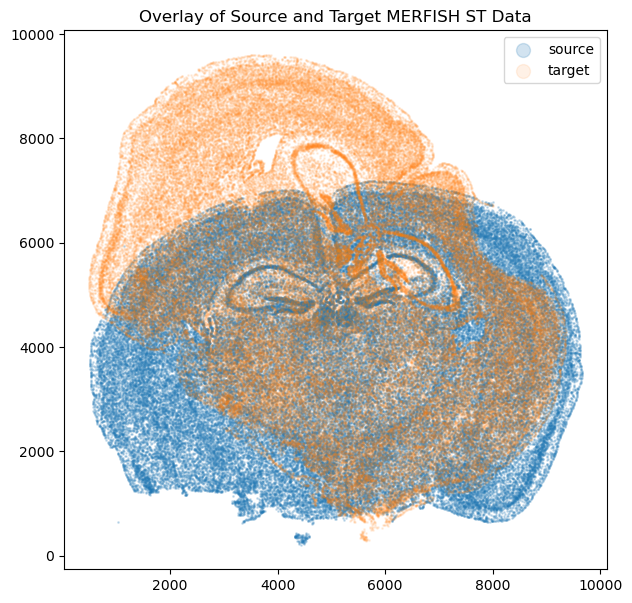

In [67]:
# STalign only needs cell centroid info, pull this 
xI = np.array(source_metadata['center_x'])
yI = np.array(source_metadata['center_y'])

xJ = np.array(target_metadata['center_x'])
yJ = np.array(target_metadata['center_y'])

# Plot 
fig,ax=plt.subplots(figsize=(7,7))
ax.scatter(xI, yI, s=1,alpha=0.2, label='source')
ax.scatter(xJ, yJ, s=1,alpha=0.1, label='target')
ax.legend(markerscale=10)
plt.title("Overlay of Source and Target MERFISH ST Data")

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


Text(0.5, 1.0, 'Rasterized Source Image')

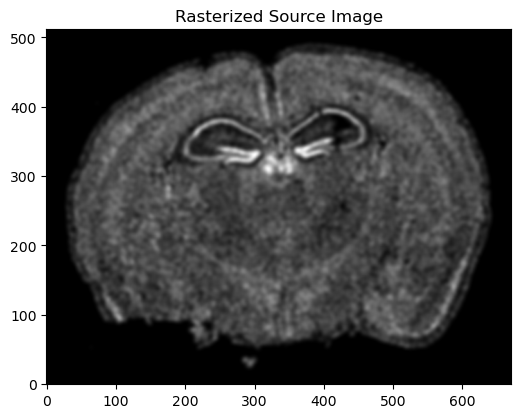

In [68]:
plt.rcParams["figure.figsize"] = (6,6)

# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,figI = STalign.rasterize(xI,yI,dx=15,blur=1.5)

# plot
ax = figI.axes[0]
ax.invert_yaxis() #have to invert y-axis to account for image typical orientation 
ax.set_title("Rasterized Source Image")

0 of 84172
10000 of 84172
20000 of 84172
30000 of 84172
40000 of 84172
50000 of 84172
60000 of 84172
70000 of 84172
80000 of 84172
84171 of 84172


Text(0.5, 1.0, 'Rasterized Target Image')

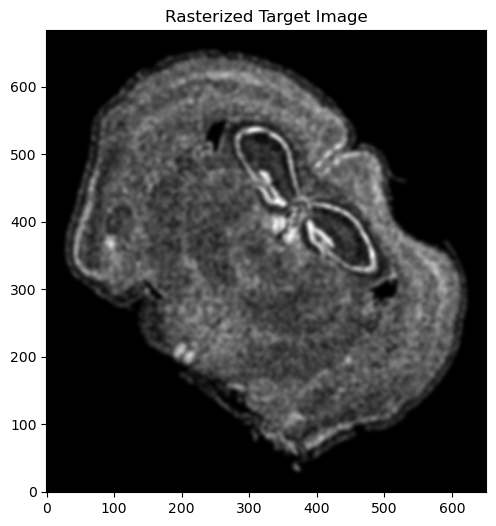

In [69]:
# rasterize the target image as well 
XJ, YJ, J, figJ = STalign.rasterize(xJ, yJ, dx=15, blur=1.5)

# plot 
ax=figJ.axes[0]
ax.invert_yaxis()
ax.set_title("Rasterized Target Image")

Text(0.5, 1.0, 'Rasterized Target Image, J')

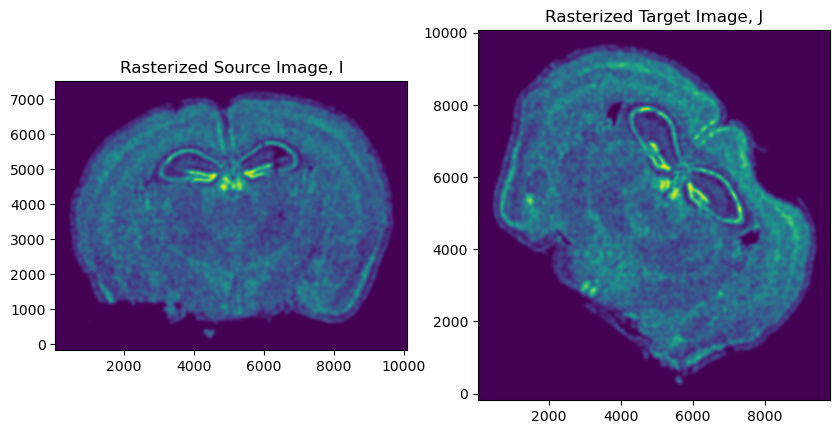

In [70]:
# plot rasterized images next to each other 
# get extent of images 
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images 
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(I[0], extent=extentI)
ax[1].imshow(J[0], extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Rasterized Source Image, I")
ax[1].set_title("Rasterized Target Image, J")

In [71]:
import landmark as lm 

Selecting 20 landmark points at threshold 0.1...
Returning sampled points...
Selecting 20 landmark points at threshold 0.1...
Returning sampled points...


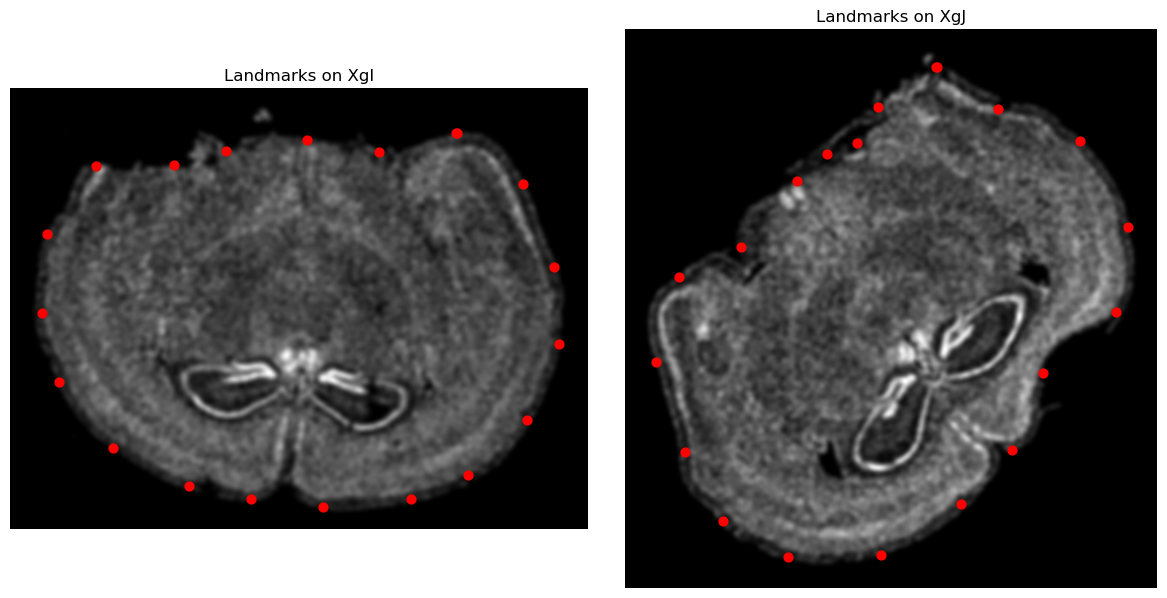

In [121]:
source_pts = lm.get_edge_landmarks(I, n_points=20, threshold=0.1)
target_pts = lm.get_edge_landmarks(J, n_points=20, threshold=0.1)

#print(source_pts.shape, target_pts.shape)
lm.visualize_points(I, J, source_pts, target_pts)

In [114]:
# copy and paste necessary functions from STalign 
def LDDMM(xI,I,xJ,J,pointsI=None,pointsJ=None,
          L=None,T=None,A=None,v=None,xv=None,
          a=500.0,p=2.0,expand=2.0,nt=3,
         niter=5000,diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
         sigmaM=1.0,sigmaB=2.0,sigmaA=5.0,sigmaR=5e5,sigmaP=2e1,
          device='cpu',dtype=torch.float64, muB=None, muA=None):
    ''' Run LDDMM between a pair of images.
    
    This jointly estimates an affine transform A, and a diffeomorphism phi.
    The map is off the form x -> A phi x
    
    
    Parameters
    ----------
    xI : list of torch tensor
        Location of voxels in source image I
    I : torch tensor
        source image I, with channels along first axis        
    xJ : list of torch tensor
        Location of voxels in target image J
    J : torch tensor
        Target image J, with channels along first axis
    L : torch tensor
        Initial guess for linear transform (2x2 torch tensor). Defaults to None (identity).
    T : torch tensor
        Initial guess for translation (2 element torch tensor). Defaults to None (identity)
    A : torch tensor
        Initial guess for affine matrix.  Either L and T can be specified, or A, but not both.
        Defaults to None (identity).
    v : torch tensor
        Initial guess for velocity field
    xv : torch tensor
        pixel locations for velocity field
    a : float
        Smoothness scale of velocity field (default 500.0)
    p : float
        Power of Laplacian in velocity regularization (default 2.0)
    expand : float
        Factor to expand size of velocity field around image boundaries (default 2.0)
    nt : int
        Number of timesteps for integrating velocity field (default 3). Ignored if you input v.
    pointsI : torch tensor
        N x 2 set of corresponding points for matching in source image. Default None (no points).
    pointsJ : torch tensor
        N x 2 set of corresponding points for matching in target image. Default None (no points).
    niter : int
        Number of iterations of gradient descent optimization
    diffeo_start : int
        Number of iterations of gradient descent optimization for affine only, before nonlinear deformation.
    epL : float
        Gradient descent step size for linear part of affine.
    epT : float
        Gradient descent step size of translation part of affine.
    epV : float
        Gradient descent step size for velocity field.
    sigmaM : float
        Standard deviation of image matching term for Gaussian mixture modeling in cost function. 
        This term generally controls matching accuracy with smaller corresponding to more accurate.
        As an common example (rule of thumb), you could chose this parameter to be the variance of the pixels
        in your target image.
    sigmaB : float
        Standard deviation of backtround term for Gaussian mixture modeling in cost function. 
        If there is missing tissue in target, we may label some pixels in target as background,
        and not enforce matching here.
    sigmaA : float
        Standard deviation of artifact term for Gaussian mixture modeling in cost function. 
        If there are artifacts in target or other lack of corresponding between template and target, 
        we may label some pixels in target as artifact, and not enforce matching here.
    sigmaR: float
        Standard deviation for regularization. Smaller sigmaR means a smoother resulting transformation. 
        Regularization is of the form: 0.5/sigmaR^2 int_0^1 int_X |Lv|^2 dx dt. 
    sigmaP: float
        Standard deviation for matching of points.  
        Cost is of the form 0.5/sigmaP^2 sum_i (source_point_i - target_point_i)^2
    device: str
        torch device. defaults to 'cpu'. Can also be 'cuda:0' for example.
    dtype: torch dtype
        torch data type. defaults to torch.float64
    muA: torch tensor whose dimension is the same as the target image
        Defaults to None, which means we estimate this. If you provide a value, we will not estimate it.
        If the target is a RGB image, this should be a tensor of size 3.
        If the target is a grayscale image, this should be a tensor of size 1.
    muB: torch tensor whose dimension is the same as the target image
        Defaults to None, which means we estimate this. If you provide a value, we will not estimate it.
        
    Returns a dictionary
    -------
    {
    'A': torch tensor
        Affine transform
    'v': torch tensor
        Velocity field
    'xv': list of torch tensor
        Pixel locations in v
    'WM': torch tensor
        Resulting weight 2D array (matching)
    'WB': torch tensor
        Resulting weight 2D array (background)
    'WA': torch tensor
        Resulting weight 2D array (artifact)
    }
    
    '''
    
    
    
    
    # todo
    # implement local?
    # more iters

    #niter = 2000
    #diffeo_start = 100
    #epL = 5e-11
    #epT = 5e-4
    #epV = 5e1
    #niter = 5000

    # check initial inputs
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    
    #L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
    ##L.data[0,0] = -1.0
    ##L.data[:2,:2] *= 0.2
    #T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
    ##T.data[0] = +2000.0
    ##T.data[1] = -xI[1][-1]/2.0*1.1

    # velocity
    #a = 500.0
    #p = 3.0
    #expand = 2.0
    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
        XV = torch.stack(torch.meshgrid(xv),-1)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True)
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = extent_from_x(xv)
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
    
    
 
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
    extentF = extent_from_x(fv)
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki.clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()


    # nt = 3
    


    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1
    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype) 
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)
    
    
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = (xJ[1][0].item()-dJ[1].item()/2.0,
          xJ[1][-1].item()+dJ[1].item()/2.0,
          xJ[0][-1].item()+dJ[0].item()/2.0,
          xJ[0][0].item()-dJ[0].item()/2.0)
    
    #sigmaM = 0.2
    #sigmaB = 0.19
    #sigmaA = 0.3
    #sigmaR = 5e5
    #sigmaP = 2e-1
    
    if muA is None:
        estimate_muA = True
    else:
        estimate_muA = False
    if muB is None:
        estimate_muB = True
    else:
        estimate_muB = False
    
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE,axE = plt.subplots(1,3)
    Esave = []

    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass
    for it in range(niter):
        # make A
        A = to_A(L,T)
        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]    
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        # and points
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):            
                pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T

        # transform image
        AI = interp(xI,I,Xs.permute(2,0,1),padding_mode="border")

        # transform the contrast
        B = torch.ones(1+AI.shape[0],AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
        B[1:AI.shape[0]+1] = AI.reshape(AI.shape[0],-1)
        #B = torch.ones(10,AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
        #B[1:4] = AI.reshape(AI.shape[0],-1)
        #B[4] = (AI[0][None]**2).reshape(1,-1)
        #B[5] = (AI[1][None]**2).reshape(1,-1)
        #B[6] = (AI[2][None]**2).reshape(1,-1)
        #B[7] = (AI[0][None]*AI[1][None]).reshape(1,-1)
        #B[8] = (AI[0][None]*AI[2][None]).reshape(1,-1)
        #B[9] = (AI[1][None]*AI[2][None]).reshape(1,-1)
        with torch.no_grad():    
            BB = B@(B*WM.ravel()).T
            BJ = B@((J*WM).reshape(J.shape[0],J.shape[1]*J.shape[2])).T
            small = 0.1
            coeffs = torch.linalg.solve(BB + small*torch.eye(BB.shape[0],device=BB.device,dtype=BB.dtype),BJ)
        fAI = ((B.T@coeffs).T).reshape(J.shape)

        # objective function
        EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER
        tosave = [E.item(), EM.item(), ER.item()]
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
        
        Esave.append( tosave )
        # gradient update
        E.backward()
        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            L.grad.zero_()
            T.grad.zero_()
            

            # v grad
            vgrad = v.grad
            # smooth it
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it >= diffeo_start:
                v -= vgrad*epV
            v.grad.zero_()


        # update weights
        if not it%5:
            with torch.no_grad():
                # M step for these params
                if estimate_muA:
                    muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
                if estimate_muB:
                    muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)
                #if it <= 200:
                #    muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                #    muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.96

                if it >= 50:

                    W = torch.stack((WM,WA,WB))
                    pi = torch.sum(W,dim=(1,2))
                    pi += torch.max(pi)*1e-6
                    pi /= torch.sum(pi)


                    # now the E step, update the weights
                    WM = pi[0]* torch.exp( -torch.sum((fAI - J)**2,0)/2.0/sigmaM**2 )/np.sqrt(2.0*np.pi*sigmaM**2)**J.shape[0]
                    WA = pi[1]* torch.exp( -torch.sum((muA[...,None,None] - J)**2,0)/2.0/sigmaA**2 )/np.sqrt(2.0*np.pi*sigmaA**2)**J.shape[0]
                    WB = pi[2]* torch.exp( -torch.sum((muB[...,None,None] - J)**2,0)/2.0/sigmaB**2 )/np.sqrt(2.0*np.pi*sigmaB**2)**J.shape[0]
                    WS = WM+WB+WA
                    WS += torch.max(WS)*1e-6
                    WM /= WS
                    WB /= WS
                    WA /= WS




        # draw
        if not it%10:
            ax[0].cla()
            ax[0].imshow(   ((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[0].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[0].set_title('space tformed source')
            
            ax[1].cla()    
            ax[1].imshow(clip(fAI.permute(1,2,0).clone().detach()/torch.max(J).item()).cpu(),extent=extentJ)
            ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[1].set_title('contrast tformed source')
            
            ax[5].cla()
            ax[5].imshow(clip( (fAI - J)/(torch.max(J).item())*3.0  ).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)
            ax[5].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[5].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[5].set_title('Error')

            ax[2].cla()
            ax[2].imshow(J.permute(1,2,0).cpu()/torch.max(J).item(),extent=extentJ)
            ax[2].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[2].set_title('Target')

            ax[4].cla()
            ax[4].imshow(clip(torch.stack((WM,WA,WB),-1).clone().detach()).cpu(),extent=extentJ)
            ax[4].set_title('Weights')


            toshow = v[0].clone().detach().cpu()
            toshow /= torch.max(torch.abs(toshow))
            toshow = toshow*0.5+0.5
            toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
            ax[3].cla()
            ax[3].imshow(clip(toshow),extent=extentV)
            ax[3].set_title('velocity')
            
            axE[0].cla()
            axE[0].plot(Esave)
            axE[0].legend(['E','EM','ER','EP'])
            axE[0].set_yscale('log')
            axE[1].cla()
            axE[1].plot([e[:2] for e in Esave])
            axE[1].legend(['E','EM'])
            axE[1].set_yscale('log')
            axE[2].cla()
            axE[2].plot([e[2] for e in Esave])
            axE[2].legend(['ER'])
            axE[2].set_yscale('log')



            fig.canvas.draw()
            figE.canvas.draw()
    
    # Compute delta energy per component
    Esave_array = np.array(Esave)
    deltaE = np.diff(Esave_array, axis=0)
    deltaE = np.vstack([np.zeros((1,Esave_array.shape[1])), deltaE])

            
    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        'Esave': Esave_array,
        'deltaE': deltaE
    }


In [115]:

def extent_from_x(xJ):
    ''' Given a set of pixel locations, returns an extent 4-tuple for use with np.imshow.
    
    Note inputs are locations of pixels along each axis, i.e. row column not xy.
    
    Parameters
    ----------
    xJ : list of torch tensors
        Location of pixels along each axis
    
    Returns
    -------
    extent : tuple
        (xmin, xmax, ymin, ymax) tuple
    
    Examples
    --------
    
    >>> extent_from_x(xJ)
    >>> fig,ax = plt.subplots()
    >>> ax.imshow(J,extent=extentJ)
    
    '''
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ

def L_T_from_points(pointsI,pointsJ):
    '''
    Compute an affine transformation from points.
    
    Note for an affine transformation (6dof) we need 3 points.
    
    Outputs, L,T should be rconstructed blockwize like [L,T;0,0,1]
    
    Parameters
    ----------
    pointsI : array
        An Nx2 array of floating point numbers describing source points in ROW COL order (not xy)
    pointsJ : array
        An Nx2 array of floating point numbers describing target points in ROW COL order (not xy)
    
    Returns
    -------
    L : array
        A 2x2 linear transform array.
    T : array
        A 2 element translation vector
    '''
    if pointsI is None or pointsJ is None:
        raise Exception('Points are set to None')
        
    nI = pointsI.shape[0]
    nJ = pointsJ.shape[0]
    if nI != nJ:
        raise Exception(f'Number of pointsI ({nI}) is not equal to number of pointsJ ({nJ})')
    if pointsI.shape[1] != 2:
        raise Exception(f'Number of components of pointsI ({pointsI.shape[1]}) should be 2')
    if pointsJ.shape[1] != 2:
        raise Exception(f'Number of components of pointsJ ({pointsJ.shape[1]}) should be 2')
    # transformation model
    if nI < 3:
        # translation only 
        L = np.eye(2)
        T = np.mean(pointsJ,0) - np.mean(pointsI,0)
    else:
        # we need an affine transform
        pointsI_ = np.concatenate((pointsI,np.ones((nI,1))),1)
        pointsJ_ = np.concatenate((pointsJ,np.ones((nI,1))),1)
        II = pointsI_.T@pointsI_
        IJ = pointsI_.T@pointsJ_
        A = (np.linalg.inv(II)@IJ).T        
        L = A[:2,:2]
        T = A[:2,-1]
    return L,T


def to_A(L,T):
    ''' Convert a linear transform matrix and a translation vector into an affine matrix.
    
    Parameters
    ----------
    L : torch tensor
        2x2 linear transform matrix
        
    T : torch tensor
        2 element translation vector (note NOT 2x1)
        
    Returns
    -------
    
    A : torch tensor
        Affine transform matrix
        
        
    '''
    O = torch.tensor([0.,0.,1.],device=L.device,dtype=L.dtype)
    A = torch.cat((torch.cat((L,T[:,None]),1),O[None]))
    return A

def interp(x,I,phii,**kwargs):
    '''
    Interpolate the 2D image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D arrays with first channel storing component)    
    
    Parameters
    ----------
    x : list of arrays
        List of arrays storing the pixel locations along each image axis. convention is row column order not xy.
    I : array
        Image array. First axis should contain different channels.
    phii : array
        Sampling array. First axis should contain sample locations corresponding to each axis.
    **kwargs : dict
        Other arguments fed into the torch interpolation function torch.nn.grid_sample
        
    
    Returns
    -------
    out : torch tensor
            The image I resampled on the points defined in phii.
    
    Notes
    -----
    Convention is to use align_corners=True.
    
    This uses the torch library.
    '''
    
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]


def clip(I):
    ''' clip an arrays values between 0 and 1.  Useful for visualizing
    
    Parameters
    ----------
    I : torch tensor
        A torch tensor to clip.
    
    Returns
    -------
    Ic : torch tensor
        Clipped torch tensor.
    
    '''
    Ic = torch.clone(I)
    Ic[Ic<0]=0
    Ic[Ic>1]=1
    return Ic



In [122]:
source_pts, target_pts

(array([[518,  51],
        [428,  73],
        [345,  59],
        [250,  72],
        [190,  89],
        [ 99,  90],
        [ 43, 169],
        [ 37, 260],
        [ 56, 341],
        [119, 417],
        [208, 461],
        [279, 477],
        [363, 486],
        [465, 477],
        [532, 449],
        [600, 385],
        [637, 296],
        [632, 207],
        [596, 111],
        [519,  51]], dtype=int32),
 array([[380,  46],
        [309,  94],
        [246, 152],
        [283, 138],
        [210, 185],
        [141, 266],
        [ 65, 303],
        [ 37, 407],
        [ 72, 517],
        [119, 601],
        [198, 646],
        [313, 643],
        [411, 581],
        [473, 515],
        [511, 420],
        [600, 345],
        [615, 241],
        [556, 136],
        [456,  97],
        [381,  46]], dtype=int32))

In [123]:
# Compute L and T
L, T = L_T_from_points(source_pts, target_pts)
print("Linear matrix L:\n", L)
print("Translation vector T:\n", T)

Linear matrix L:
 [[ 0.82637688  0.20125463]
 [-0.38534226  1.09423598]]
Translation vector T:
 [-17.48609903 177.49341166]


In [124]:
A = to_A(torch.tensor(L),torch.tensor(T))

In [125]:
XctI = (I - np.min(I))/(np.max(I)-np.min(I))
XctJ = (J - np.min(J))/(np.max(J)-np.min(J))

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/1829809456.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/1829809456.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/1829809456.py:389: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


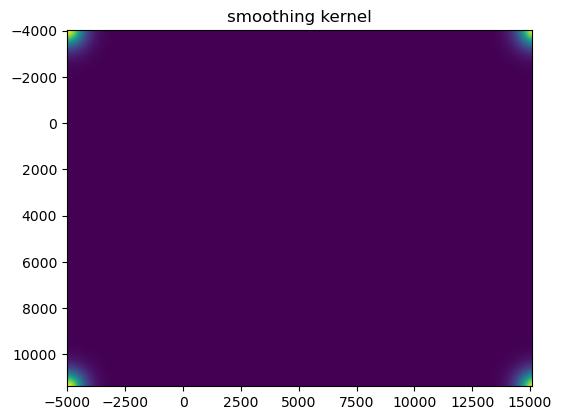

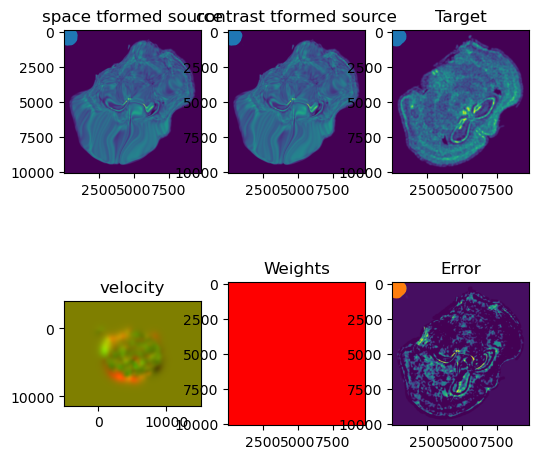

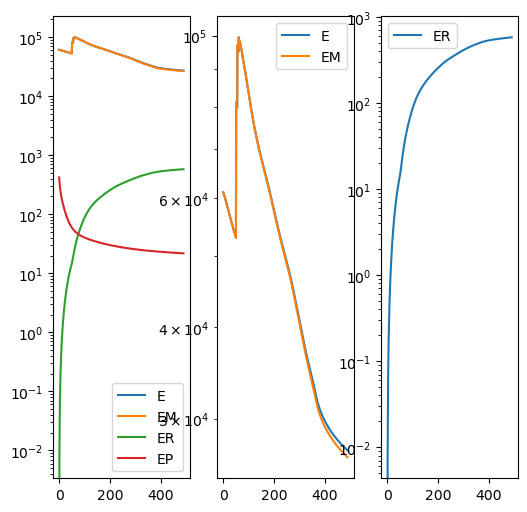

In [130]:
#%%time
# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
            'niter': 500,
            'a':200,
            'pointsI': source_pts,
            'pointsJ': target_pts,
            'sigmaM': 0.25,
            'device':device,
          }

out = LDDMM([YI,XI],
            I,
            [YJ,XJ],
            J, 
            **params)

Text(0.5, 1.0, 'ER across 200 iterations with a = 500')

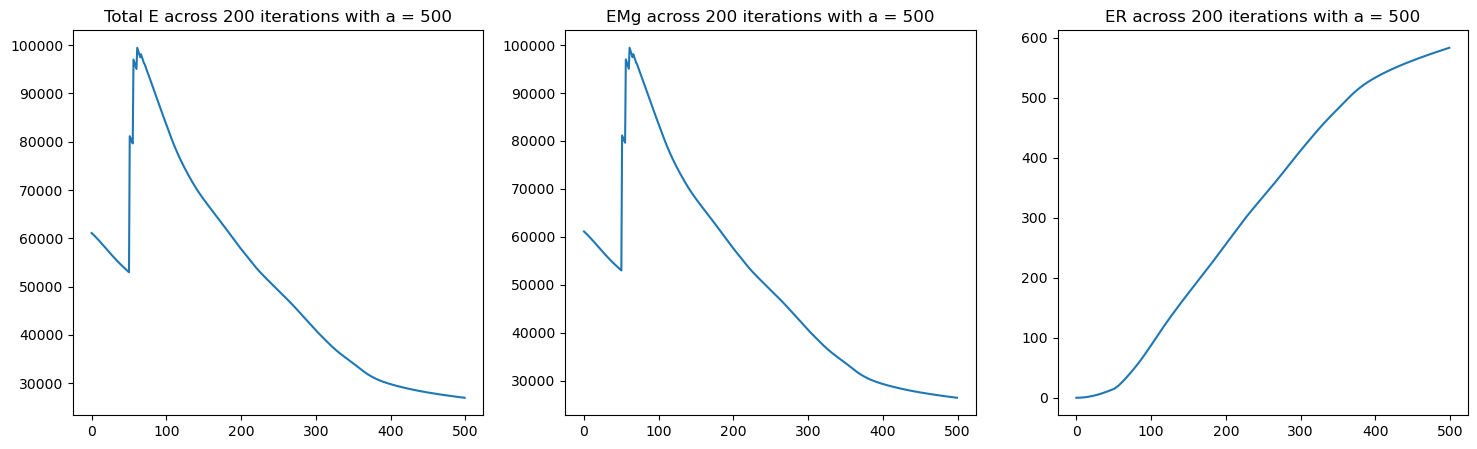

In [131]:
Esave = out['Esave']
# Esave saves total, EMg, and ER 
n_iter = 200 
fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].plot(Esave[:,0]) 
ax[0].set_title(f"Total E across {n_iter} iterations with a = 500")
ax[1].plot(Esave[:,1]) 
ax[1].set_title(f"EMg across {n_iter} iterations with a = 500")
ax[2].plot(Esave[:,2]) 
ax[2].set_title(f"ER across {n_iter} iterations with a = 500")

In [132]:
total_E = Esave[:,0]
final_E = total_E[-1] 
delta_total_E = total_E[0] - final_E
final_E, delta_total_E

(26986.11606789295, 34118.606406952706)

In [133]:
A = out['A']
v = out['v']
xv = out['xv']

In [134]:
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], axis=1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

Text(0.5, 1.0, 'Original LDDMM with Cell Density')

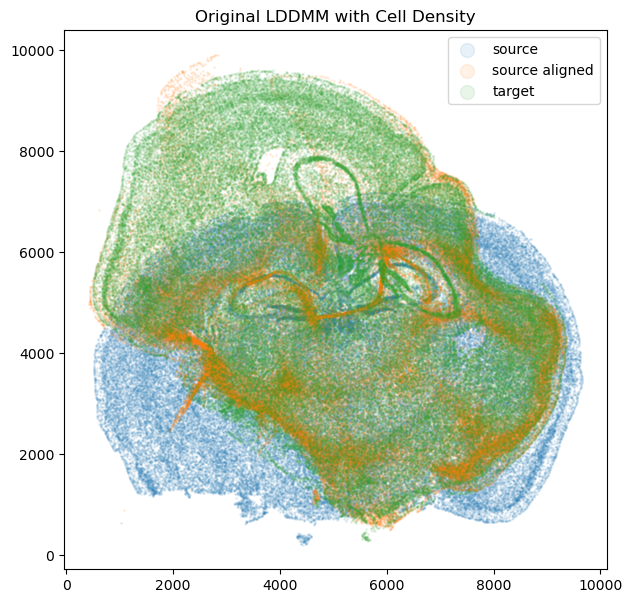

In [135]:
# plot results
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)
ax.set_title("Original LDDMM with Cell Density")

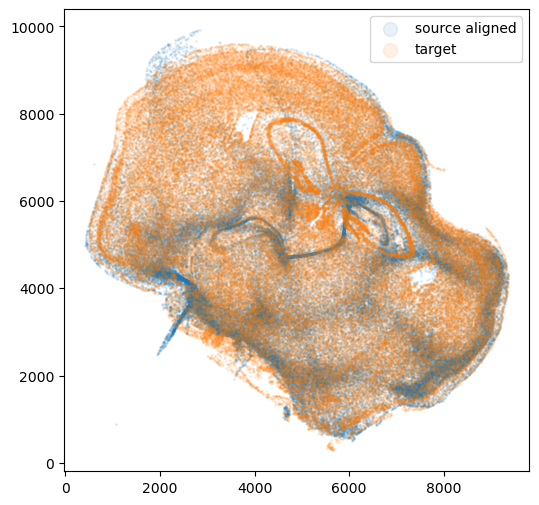

In [136]:
# plot results
fig,ax = plt.subplots()
# ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/1829809456.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/1829809456.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/1829809456.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.ten

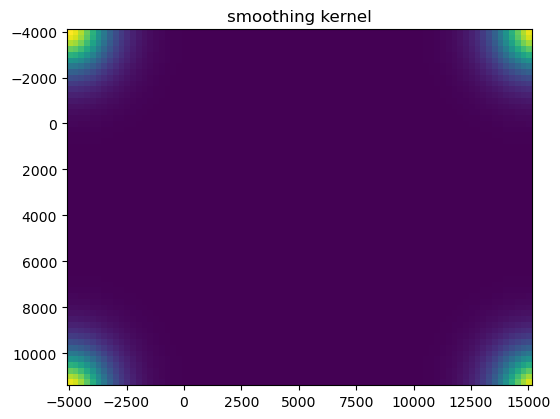

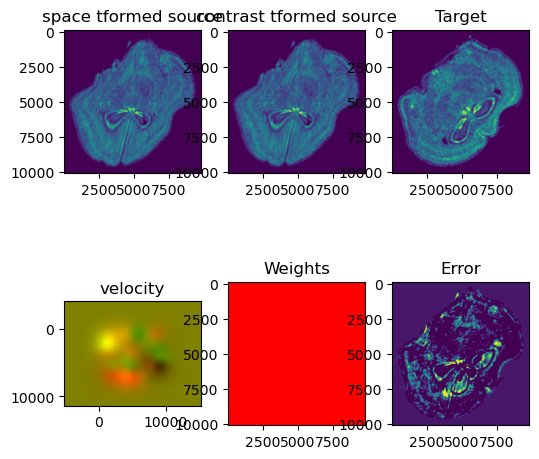

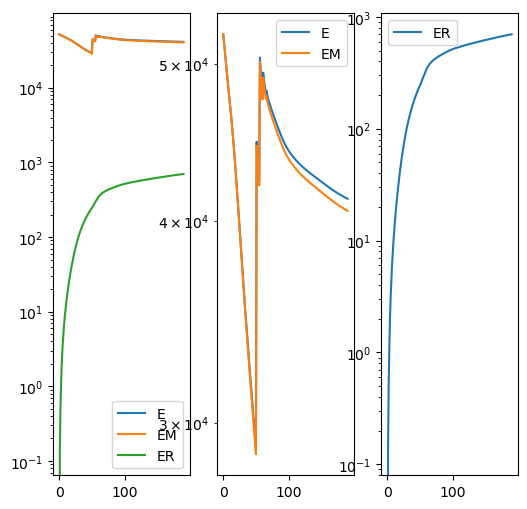

In [161]:
#%%time
# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
            'niter': 200,
            'a':500,
            # 'pointsI': source_pts,
            # 'pointsJ': target_pts,
            'sigmaM': 0.25,
            'device':device,
            'A':A
            # 'epV': 50
          }

out = LDDMM([YI,XI],I,[YJ,XJ],J,**params)

Text(0.5, 1.0, 'ER across 200 iterations with a = 200')

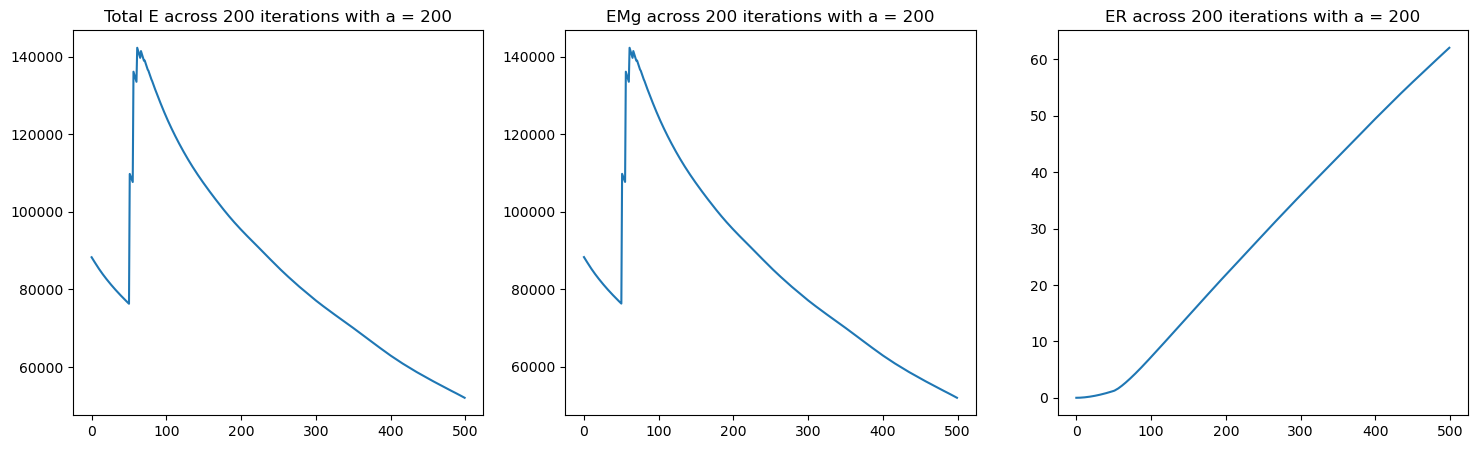

In [156]:
Esave = out['Esave']
# Esave saves total, EMg, and ER 
n_iter = 200 
fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].plot(Esave[:,0]) 
ax[0].set_title(f"Total E across {n_iter} iterations with a = 200")
ax[1].plot(Esave[:,1]) 
ax[1].set_title(f"EMg across {n_iter} iterations with a = 200")
ax[2].plot(Esave[:,2]) 
ax[2].set_title(f"ER across {n_iter} iterations with a = 200")

In [163]:
total_E = Esave[:,0]
final_E = total_E[-1] 
delta_total_E = total_E[0] - final_E
final_E, delta_total_E

(52056.3250964982, 36216.85341150475)

In [164]:
A = out['A']
v = out['v']
xv = out['xv']

In [165]:
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], axis=1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

Text(0.5, 1.0, 'Original LDDMM with Cell Density')

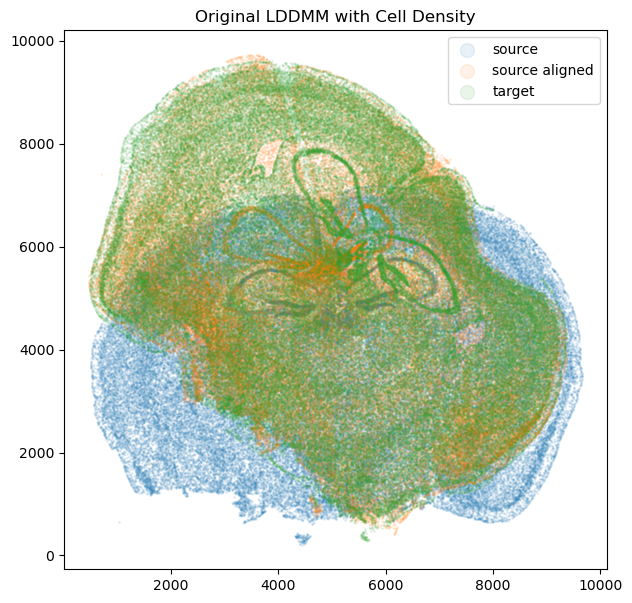

In [166]:
# plot results
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)
ax.set_title("Original LDDMM with Cell Density")

Text(0.5, 1.0, 'Original LDDMM with Cell Density')

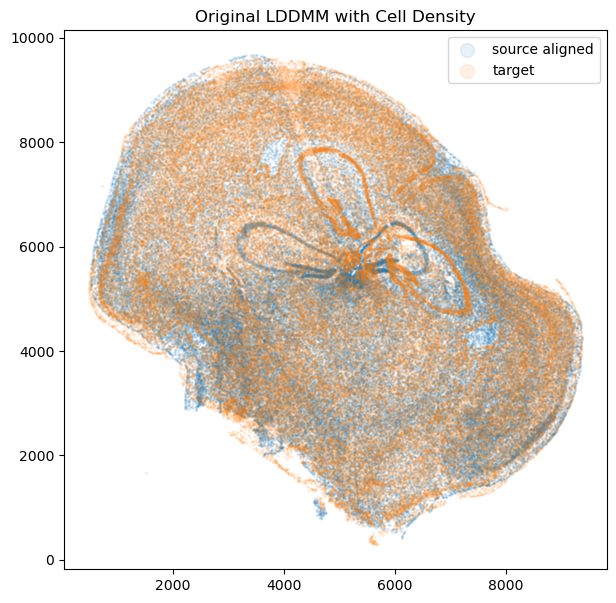

In [143]:
# plot results
fig,ax = plt.subplots(figsize=(7,7))
#ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)
ax.set_title("Original LDDMM with Cell Density")

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/1829809456.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/1829809456.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/1829809456.py:389: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


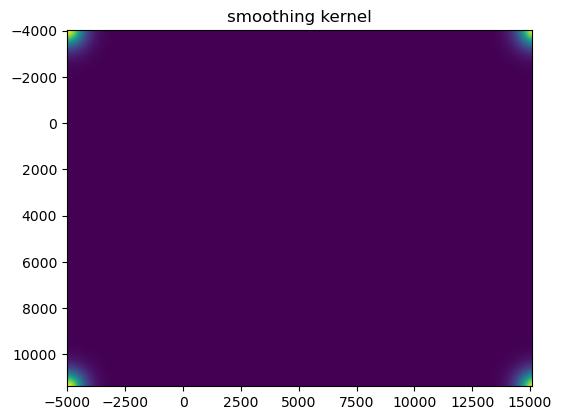

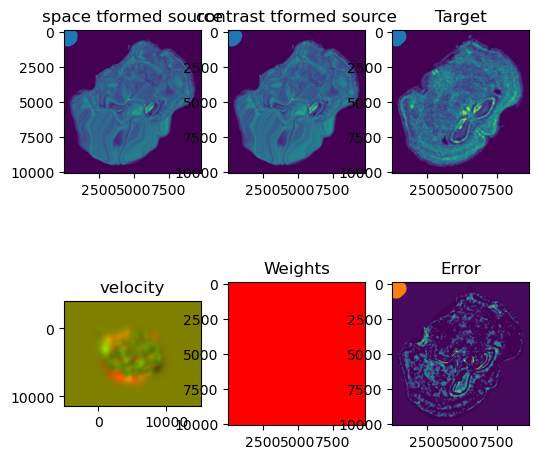

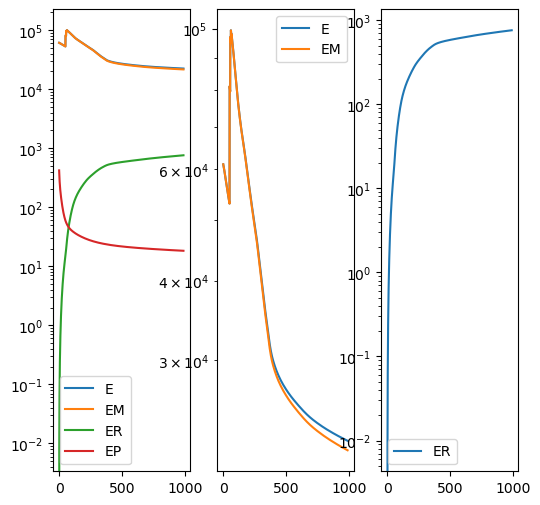

In [144]:
#%%time
# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
            'niter': 1000,
            'a':200,
            'pointsI': source_pts,
            'pointsJ': target_pts,
            'sigmaM': 0.25,
            'device':device,
            #'epV': 50
          }

out = LDDMM([YI,XI],I,[YJ,XJ],J,**params)

Text(0.5, 1.0, 'ER across 500 iterations with a = 200')

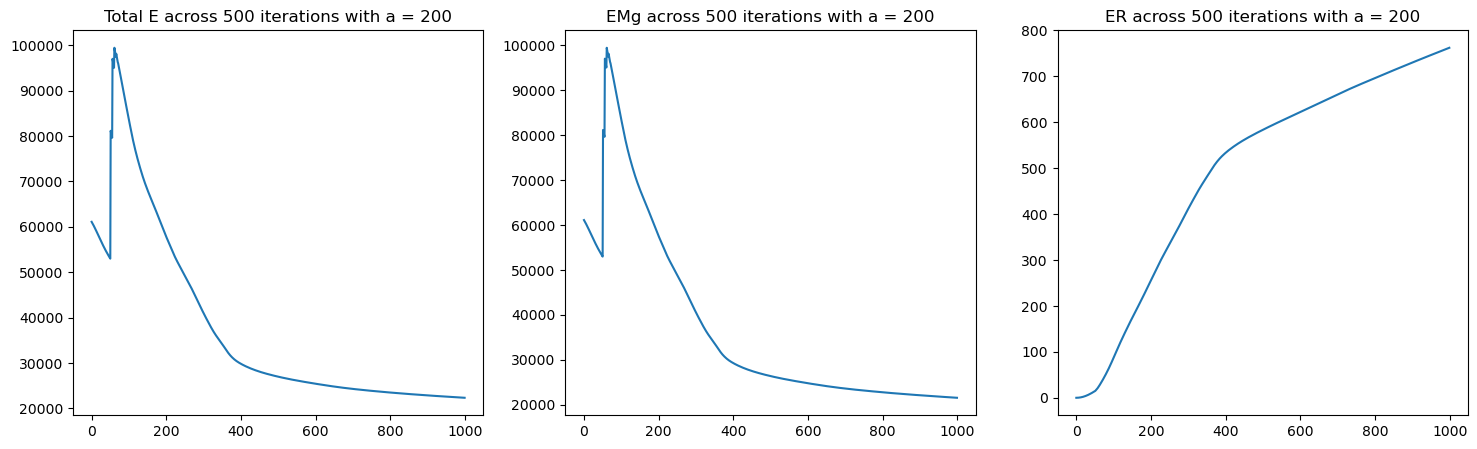

In [145]:
Esave = out['Esave']
# Esave saves total, EMg, and ER 
n_iter = 500
fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].plot(Esave[:,0]) 
ax[0].set_title(f"Total E across {n_iter} iterations with a = 200")
ax[1].plot(Esave[:,1]) 
ax[1].set_title(f"EMg across {n_iter} iterations with a = 200")
ax[2].plot(Esave[:,2]) 
ax[2].set_title(f"ER across {n_iter} iterations with a = 200")

In [146]:
total_E = Esave[:,0]
final_E = total_E[-1] 
delta_total_E = total_E[0] - final_E
final_E, delta_total_E

(22325.257173193422, 38779.46530165223)

In [147]:
A = out['A']
v = out['v']
xv = out['xv']

In [148]:
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], axis=1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

Text(0.5, 1.0, 'Original LDDMM with Cell Density')

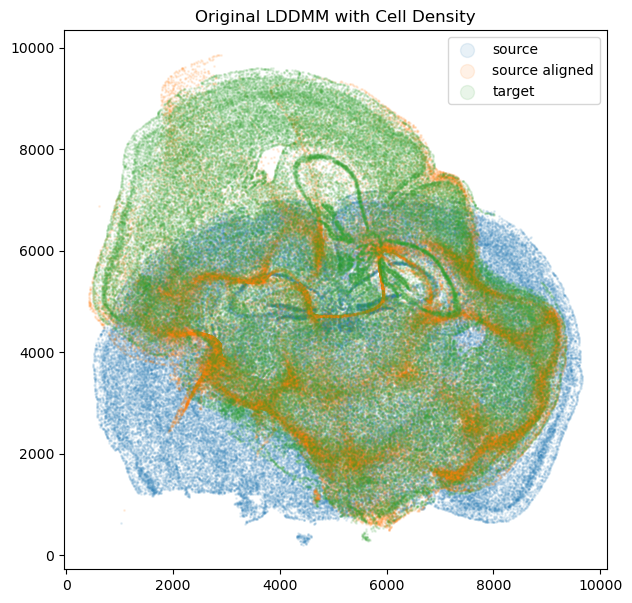

In [149]:
# plot results
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)
ax.set_title("Original LDDMM with Cell Density")

Text(0.5, 1.0, 'Original LDDMM with Cell Density')

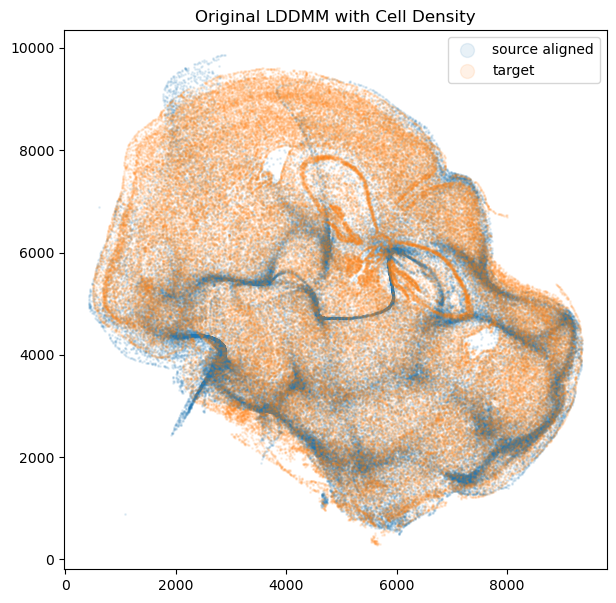

In [150]:
# plot results
fig,ax = plt.subplots(figsize=(7,7))
#ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)
ax.set_title("Original LDDMM with Cell Density")

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/3035184685.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/3035184685.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_4244/3035184685.py:388: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


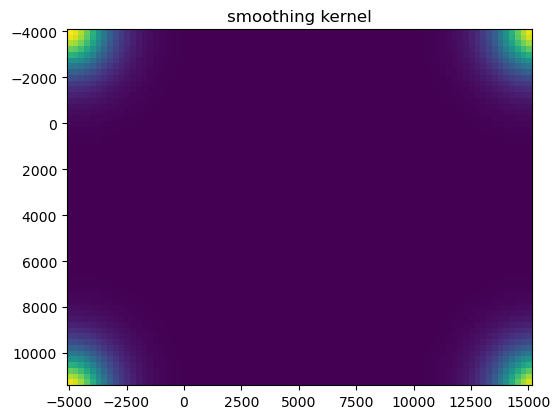

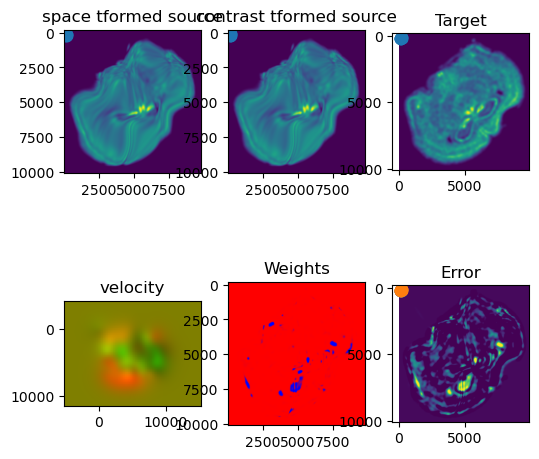

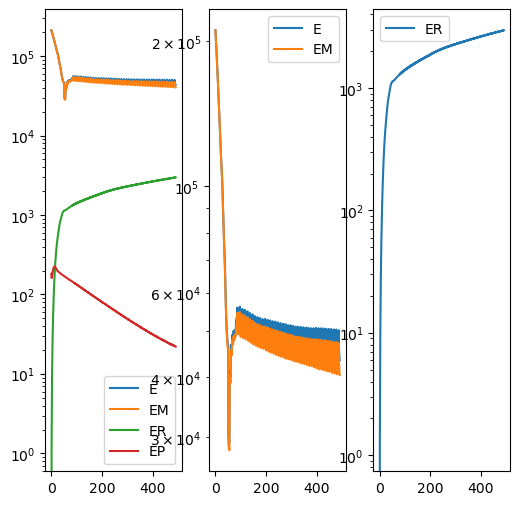

In [57]:
#%%time
# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
            'niter': 500,
            'a':500,
            'pointsI': source_pts,
            'pointsJ': target_pts,
            'sigmaM': 0.25,
            'device':device,
          }

out = LDDMM([YI,XI],I,[YJ,XJ],J,**params)

Text(0.5, 1.0, 'ER across 500 iterations with a=500')

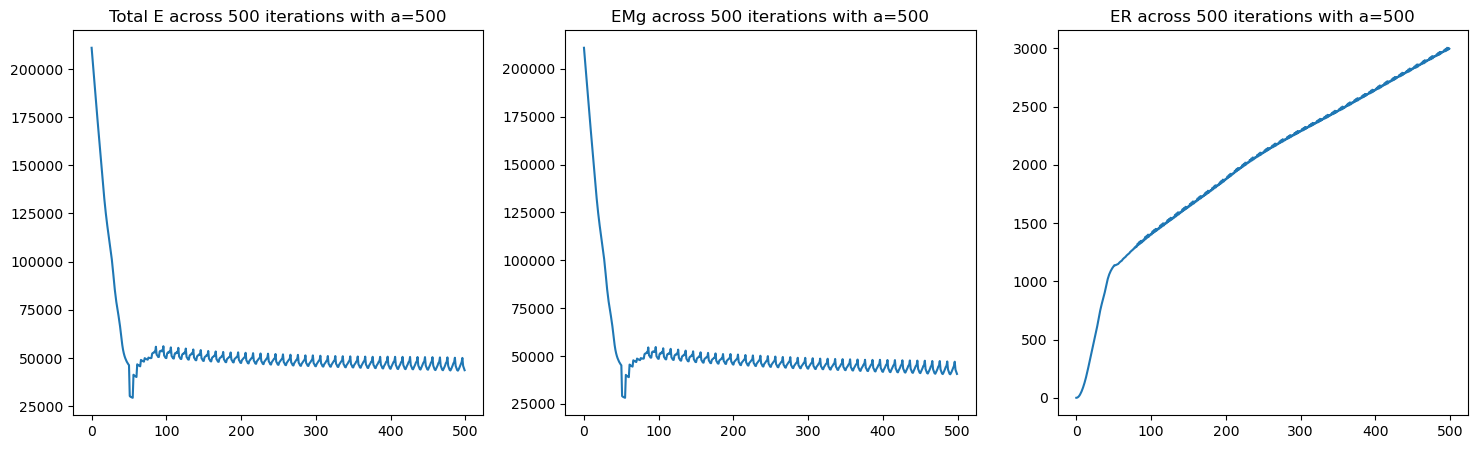

In [59]:
Esave = out['Esave']
# Esave saves total, EMg, and ER 
n_iter = 500 
fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].plot(Esave[:,0]) 
ax[0].set_title(f"Total E across {n_iter} iterations with a=500")
ax[1].plot(Esave[:,1]) 
ax[1].set_title(f"EMg across {n_iter} iterations with a=500")
ax[2].plot(Esave[:,2]) 
ax[2].set_title(f"ER across {n_iter} iterations with a=500")

In [60]:
total_E = Esave[:,0]
final_E = total_E[-1] 
delta_total_E = total_E[0] - final_E
final_E, delta_total_E

(43641.64488201369, 167362.73471060145)

Text(0.5, 1.0, 'Original LDDMM with Cell Density')

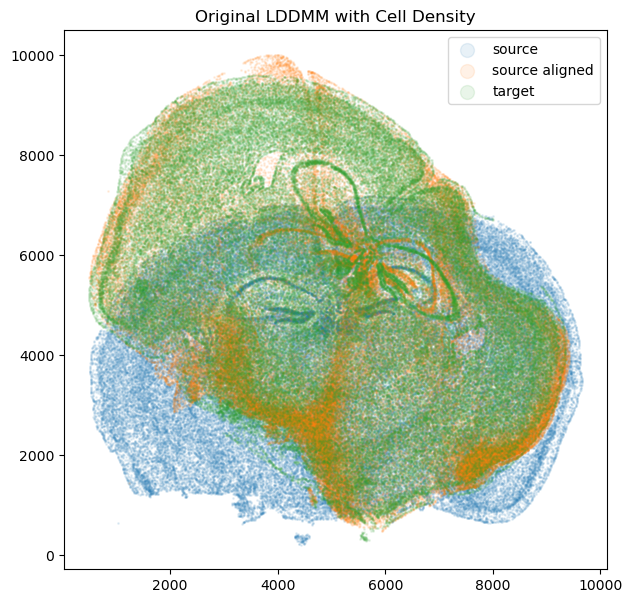

In [ ]:
A = out['A']
v = out['v']
xv = out['xv']

# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], axis=1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

# plot results
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)
ax.set_title("Original LDDMM with Cell Density")

Text(0.5, 1.0, 'Original LDDMM with Cell Density')

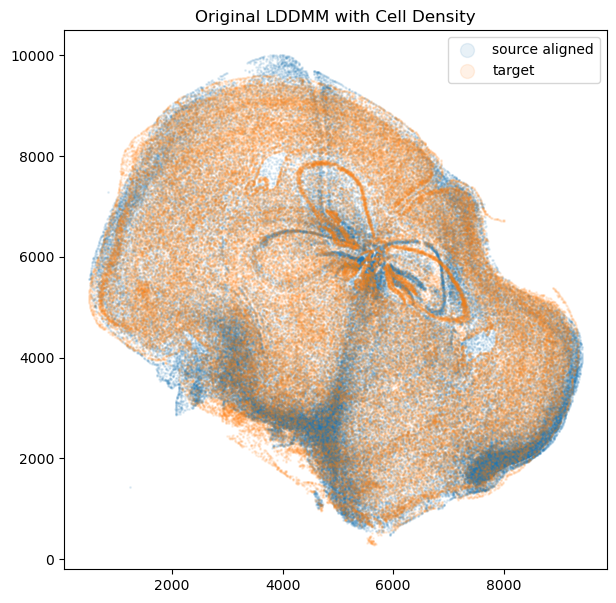

In [64]:
# plot results
fig,ax = plt.subplots(figsize=(7,7))
#ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)
ax.set_title("Original LDDMM with Cell Density")